# Dask Bag

Dask's bag collection provides useful functional programming operations.

The underlying operations are applied to Python lists or iterators.

Dask bags are useful for unstructured or semi-structured data e.g. JSON.

## Example One

Let's sum all the numbers from 0 to 1 billion.

In [107]:
import dask.bag as db

n = int(1e09) + 1

## Normal Python Code

In [108]:
%%time
number_generator = range(n)
sum(number_generator)

CPU times: user 14.9 s, sys: 39.8 ms, total: 15 s
Wall time: 15 s


## Dask Code

Dask collections delay any computation until `compute` is called. The job of a collection is to describe the computation in a graph structure which is then executed by the scheduler.

This is illustrated below on a smaller range.

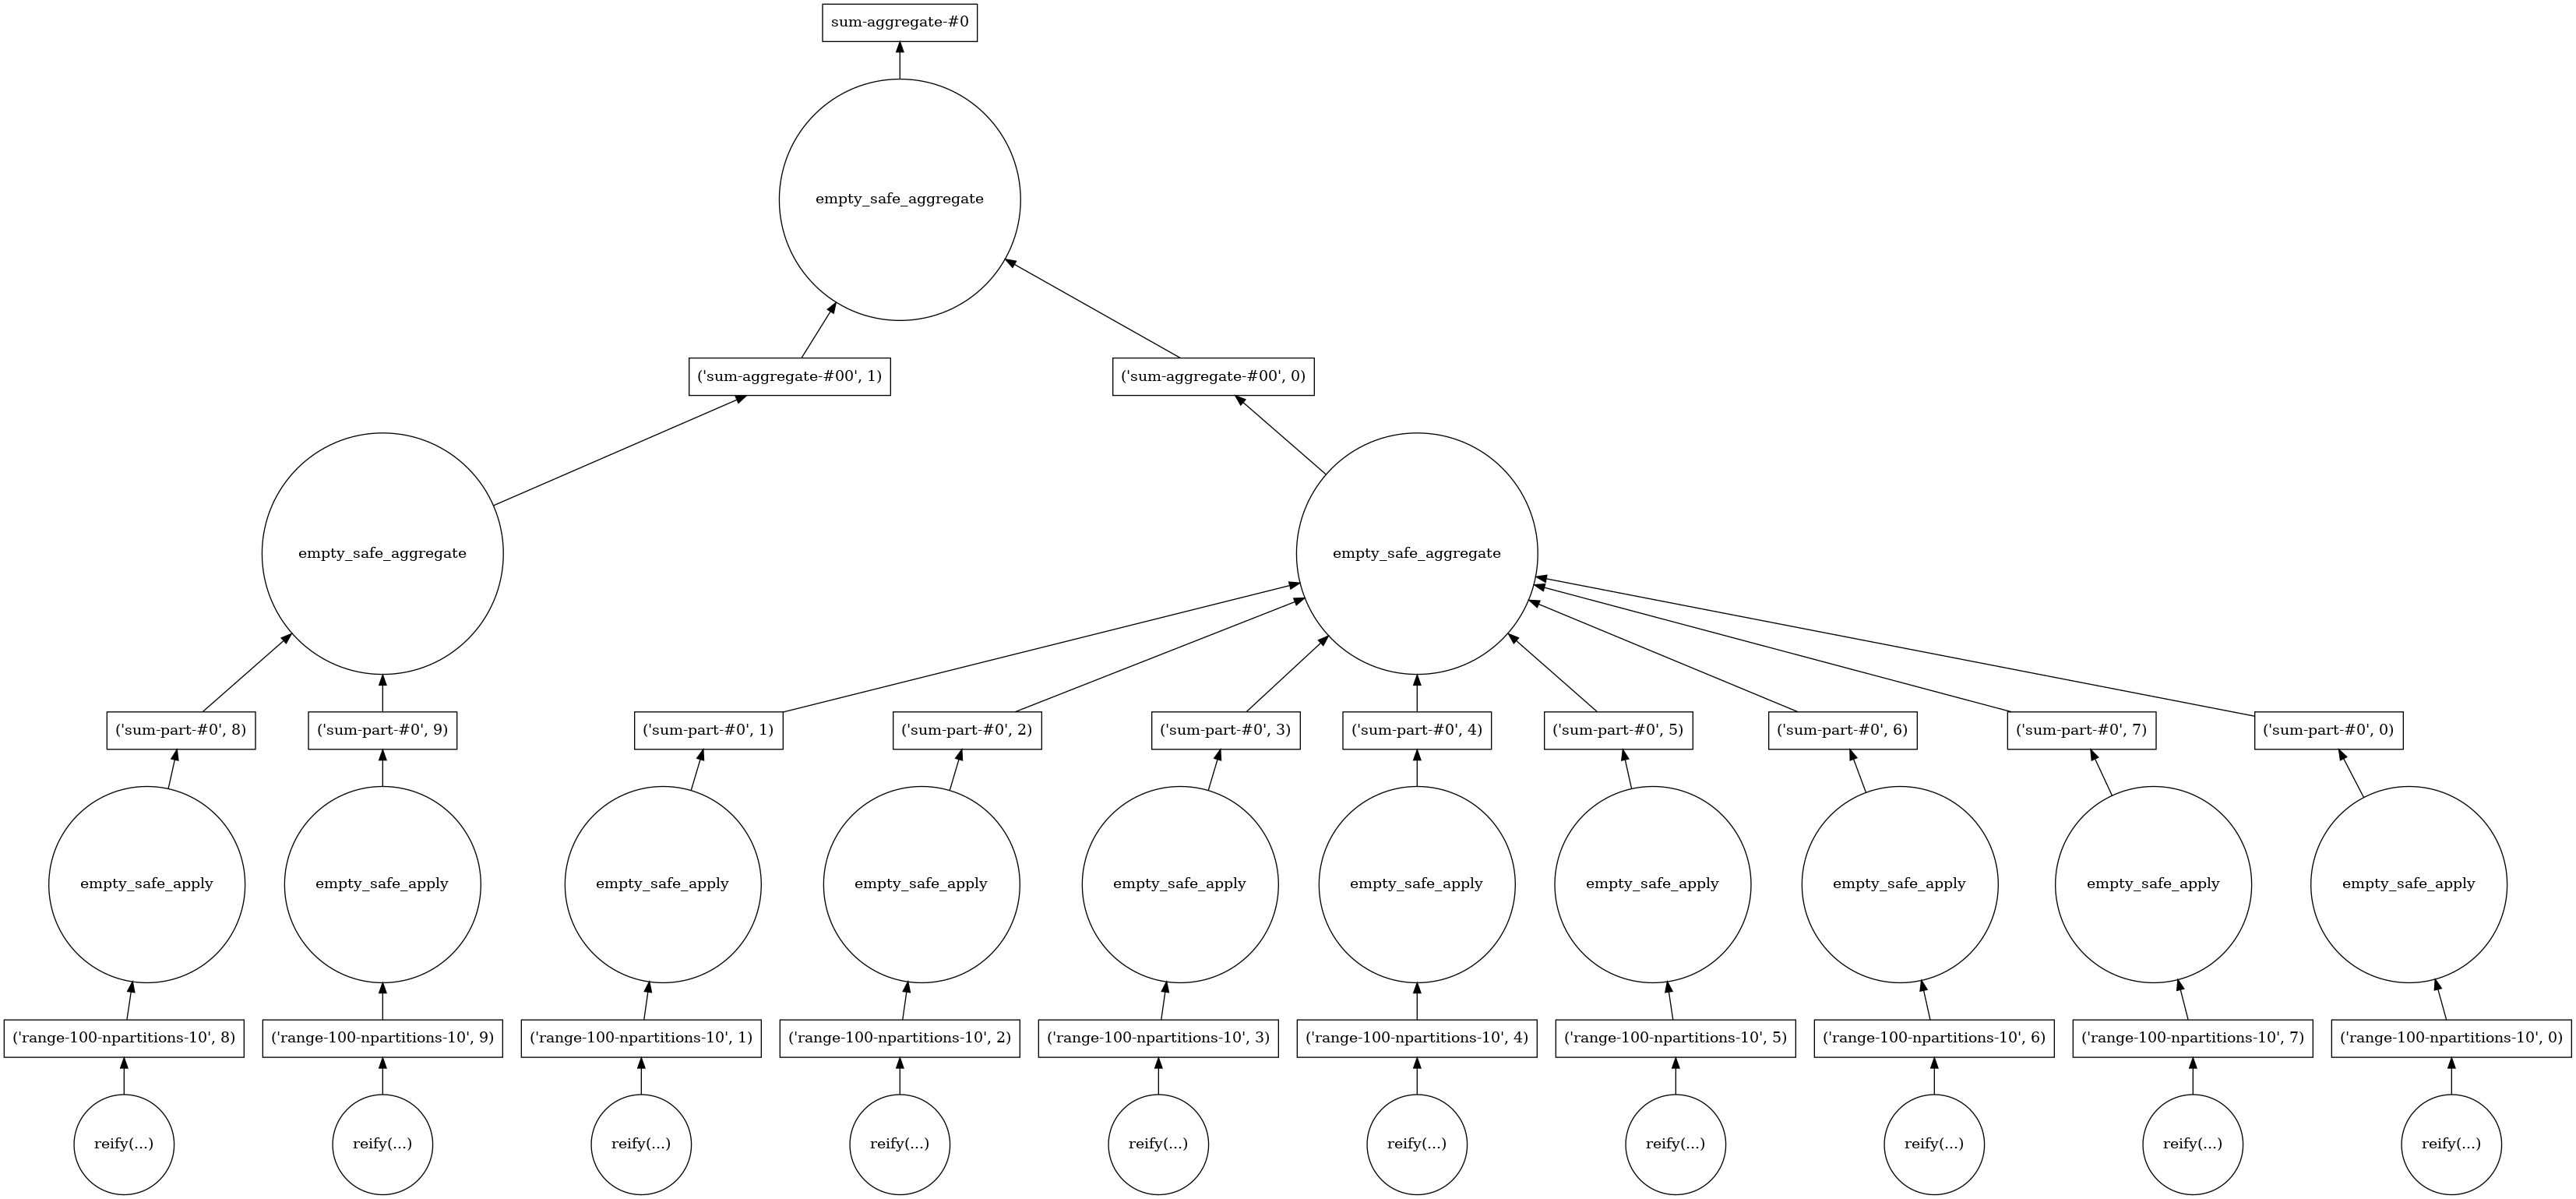

In [109]:
# Generate a range of numbers
number_generator = db.range(100, 10)

# Sum all the numbers within that range
sum_task = number_generator.sum()

# Visualize the task graph
sum_task.visualize()

In [110]:
%%time
# Generate a range of numbers
number_generator = db.range(n, 1000)

# Sum all the numbers within that range
sum_task = number_generator.sum()

# Visualize the task graph
sum_task.compute()

CPU times: user 559 ms, sys: 73.5 ms, total: 633 ms
Wall time: 4.6 s


# Example Two

Apply a classic groupby type operation to 10 million data points.

In [161]:
from random import choice
from itertools import groupby
from dask import delayed

n = int(10e6)

In [164]:
def generate_data(n) -> str:
    """Generate n random choices from the CHOICES tuple"""
    
    CHOICES = ('cat', 'dog')
    for i in range(n):
        yield choice(CHOICES)

## Python Code

In [165]:
%%time
counts = {}
for key, group in groupby(generate_data(n)):
    counts.setdefault(key, 0)
    counts[key] += len(list(group))
    
print(counts, '\n')

{'dog': 5000838, 'cat': 4999162} 

CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 11.2 s


## Dask Code

Again let's first visualize the task graph with smaller inputs.

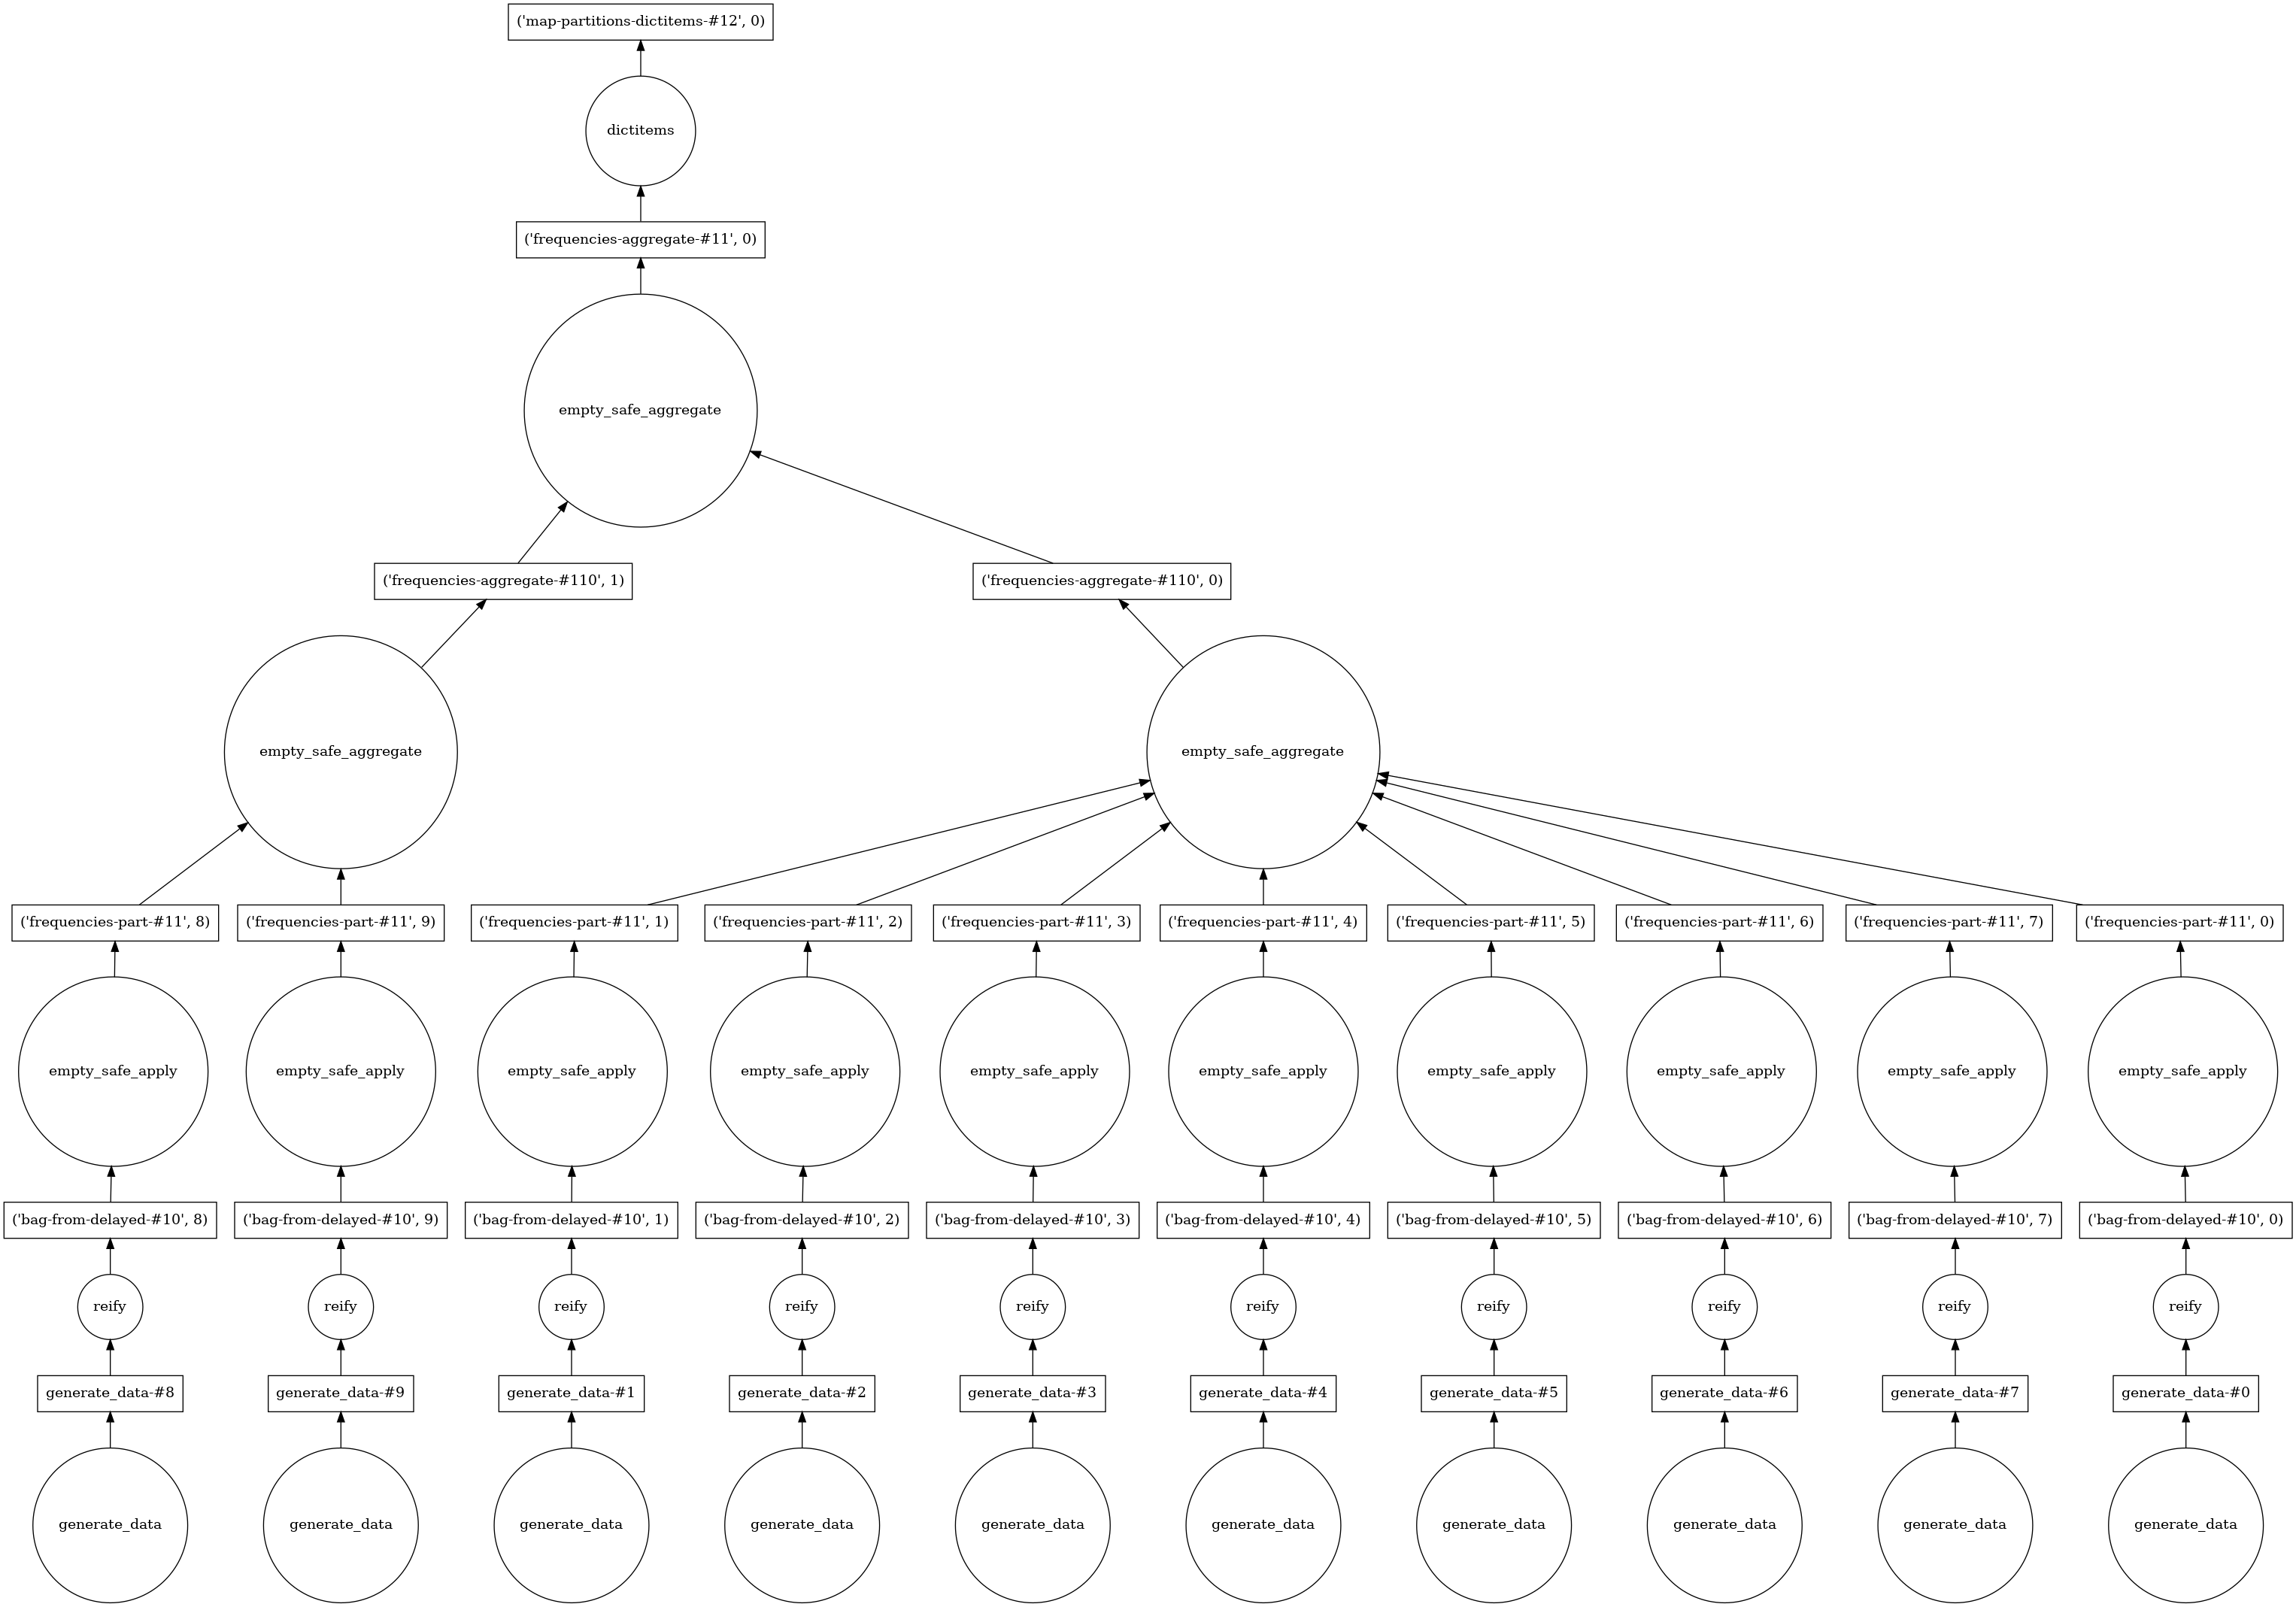

In [166]:
chunk_size = 10

batches = []
for i in range(100 // chunk_size):
    batches.append(
        delayed(generate_data)(10000)
    )
    
graph = (
    db.from_delayed(batches)
        .frequencies()
)

graph.visualize()

In [170]:
%%time
chunk_size = 10000

batches = []
for i in range(n // chunk_size):
    batches.append(
        delayed(generate_data)(chunk_size)
    )
    
counts = (
    db.from_delayed(batches)
        .frequencies()
        .compute()
)

print(dict(counts), '\n')

{'dog': 4978000, 'cat': 5022000} 

CPU times: user 2.35 s, sys: 66.4 ms, total: 2.41 s
Wall time: 3.77 s
